In [224]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

nuclides = {'helium-6': 806.7e-3, 
            'carbon-14': 181e9,
            'uranium-235': 22.2e15}

def sim(n0, lamb, step):
    n = n0
    y = [n]
    keep = np.exp(-step * lamb)
    while n > 0:
        for i in range(n):
            if np.random.random() > keep:
                n -= 1
                if n == 0:
                    break
        y.append(n)
    return y

def decay(n0, lamb, step, length):
    n = n0
    y = [n]
    keep = np.exp(-step * lamb)
    for i in range(length - 1):
        n *= keep
        y.append(n)
    return y

def compare(n0, step, t12):
    lamb = np.log(2)/t12
    y1 = sim(n0, lamb, step)
    y2 = decay(n0, lamb, step, len(y1))
    x = np.arange(0, step * (len(y2) - .5), step)
    f = plt.figure(figsize=(12,6))
    plt.plot(x, y2, color='#e41a1c')
    plt.plot(x, y1, color='#377eb8')
    plt.ylabel('N(t)')
    plt.xlabel('t [s]')
    plt.legend(['Theory', 'Simulation'], loc='upper right')    
    plt.show()
    
def compare_multiple(n0, step, t12, nsims, a, title):
    lamb = np.log(2)/t12
    sims = []
    for i in range(nsims):
        sims.append(sim(n0, lamb, step))
    y2 = decay(n0, lamb, step, max([len(s) for s in sims]))
    x = np.arange(0, step * (len(y2) - .5), step)
    f = plt.figure(figsize=(12,6))
    plt.plot(x, y2, color='#e41a1c')
    for s in sims:
        y = np.zeros(len(y2))
        y[:len(s)] = s
        plt.plot(x, y, color='#377eb8', alpha=a)
    plt.ylabel('N(t)')
    plt.xlabel('t [s]')
    plt.legend(['Theory', 'Simulation'], loc='upper right')
    plt.suptitle(title)
    
def nuclide_compare(n0, nuclide):
    t12 = nuclides[nuclide]
    step = np.log2(n0)*t12/1e4
    return compare(n0, step, t12)

def nuclide_compare_multiple(n0, nuclide, nsims=10, a=.2):
    t12 = nuclides[nuclide]
    step = np.log2(n0)*t12/1e4
    return compare_multiple(n0, step, t12, nsims, a, nuclide)

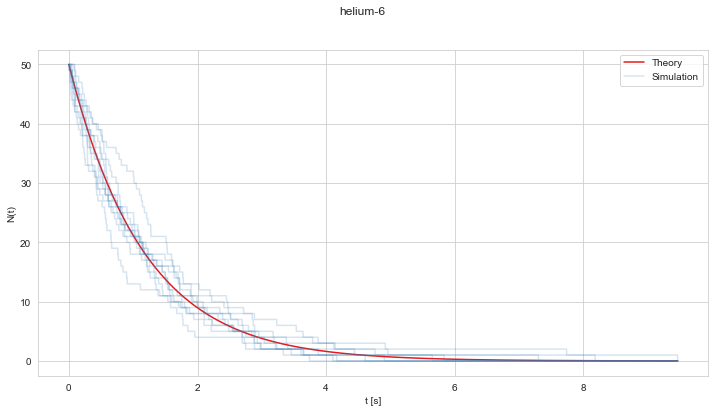

In [233]:
nuclide_compare_multiple(50,'helium-6')

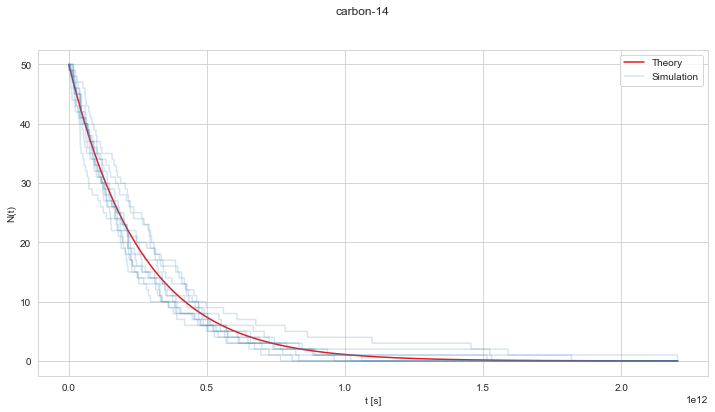

In [229]:
nuclide_compare_multiple(50,'carbon-14')

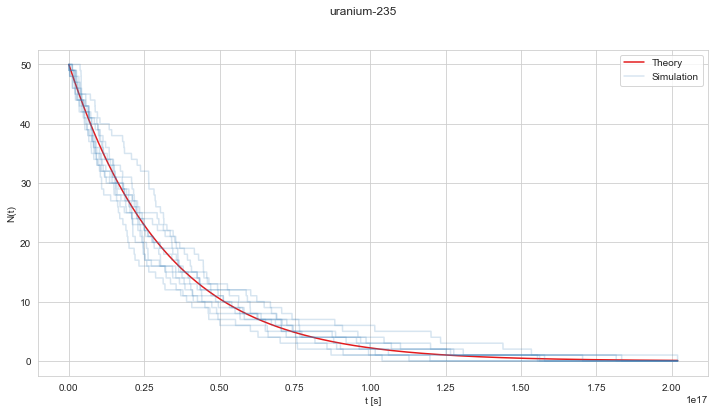

In [230]:
nuclide_compare_multiple(50,'uranium-235')